In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=scipy.integrate.IntegrationWarning)

Создадим класс для работы с трапециевидными нечёткими множествами.

In [55]:
def trapezoid_mf(a, b, c, d):
    return lambda x: \
      0 if x <= a or x >= d else \
      (x - a) / (b - a) if a < x <= b else \
      1 if b <= x <= c else \
      (d - x) / (d - c) if c < x <= d else \
      None

class FuzzySet:
  def __init__(self, a, b, c, d):
    self.mf = trapezoid_mf(a, b, c, d)
    self.min, self.max = a, d
    self.a, self.b, self.c, self.d = a, b, c, d

  def plot(self, axes=plt):
    xs = np.linspace(self.min, self.max, 100)
    ys = [self.mf(x) for x in xs]
    axes.plot(xs, ys)

  def specificity(self, u):
    ''' u - размер универсума '''
    return 1 - (self.c + self.d - (self.a + self.b)) / u

Для упрощения кода оформим в отдельную функцию построение гистограммы (как функции!) по набору данных.

In [56]:
def histogram(data, bins):
  hist, bin_edges = np.histogram(data, bins, density=True)
  def h(x):
    for i in range(len(hist)):
      if bin_edges[i] <= x < bin_edges[i + 1]:
        return hist[i]
    return 0
  return h

Сгенерируем выборку размера 1000 из смеси гауссовских распределений $\mathcal N(0,1)$ и $\mathcal N(2,1)$. Для наглядности построим гистограмму.

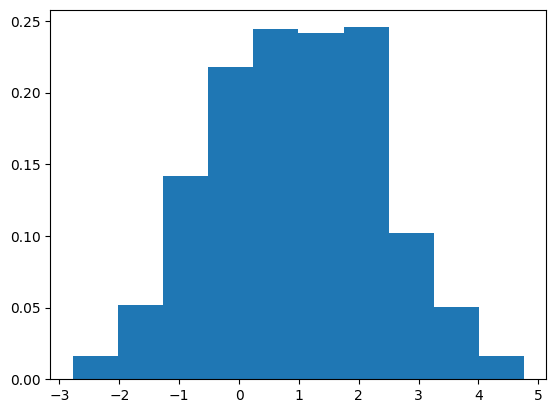

In [62]:
np.random.seed(0)
data = np.hstack([
    np.random.normal(0, 1, 500),
    np.random.normal(2, 1, 500)
])
plt.hist(data, density=True)
plt.show()

Выведем набор данных:

In [63]:
data

array([ 1.76405235e+00,  4.00157208e-01,  9.78737984e-01,  2.24089320e+00,
        1.86755799e+00, -9.77277880e-01,  9.50088418e-01, -1.51357208e-01,
       -1.03218852e-01,  4.10598502e-01,  1.44043571e-01,  1.45427351e+00,
        7.61037725e-01,  1.21675016e-01,  4.43863233e-01,  3.33674327e-01,
        1.49407907e+00, -2.05158264e-01,  3.13067702e-01, -8.54095739e-01,
       -2.55298982e+00,  6.53618595e-01,  8.64436199e-01, -7.42165020e-01,
        2.26975462e+00, -1.45436567e+00,  4.57585173e-02, -1.87183850e-01,
        1.53277921e+00,  1.46935877e+00,  1.54947426e-01,  3.78162520e-01,
       -8.87785748e-01, -1.98079647e+00, -3.47912149e-01,  1.56348969e-01,
        1.23029068e+00,  1.20237985e+00, -3.87326817e-01, -3.02302751e-01,
       -1.04855297e+00, -1.42001794e+00, -1.70627019e+00,  1.95077540e+00,
       -5.09652182e-01, -4.38074302e-01, -1.25279536e+00,  7.77490356e-01,
       -1.61389785e+00, -2.12740280e-01, -8.95466561e-01,  3.86902498e-01,
       -5.10805138e-01, -

Оформим в отдельную функцию вычисление B-части Z-числа при фиксированной A-части. Используемый метод описан в разделе 4.1 исследовательской работы.

In [58]:
def calculateB(A: FuzzySet, data, bins_min=3, bins_max=None, bins_best=None):
  if not bins_max:
    # наибольшее количество интервалов
    bins_max = len(data)
  if not bins_best:
    # варианты "оптимального" количества интервалов - используются для выбора вершины
    bins_best = [np.ceil(np.log(len(data)) / np.log(2)), np.ceil(np.sqrt(len(data)))]
  a, b = min(data.min(), A.a), max(data.max(), A.d)
  similarities = []
  best_sim = []
  for bins in tqdm(range(bins_min, bins_max + 1)):
    similarity = scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, bins)(x), a=a, b=b)[0]
    similarities.append(similarity)
    if bins in bins_best:
      best_sim.append((bins, similarity))
  plt.plot(range(bins_min, bins_max + 1), similarities)
  plt.title('График зависимости степени уверенности от количества интервалов')
  plt.show()
  print(f"Support of B = [{min(similarities)}, {max(similarities)}]")
  print(f"Possible peaks of B are:\n", best_sim)
  return list(map(lambda c: FuzzySet(min(similarities), c[1], c[1], max(similarities)), best_sim))

Зафиксируем A-часть Z-числа:

In [59]:
A = FuzzySet(-2, 0, 3, 4)

Запустим вычисления.

100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


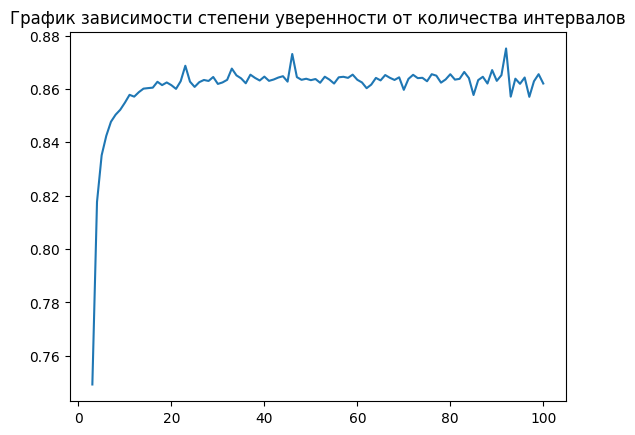

Support of B = [0.7492147774312885, 0.8751799662002084]
Possible peaks of B are:
 [(10, 0.8548589719506802), (32, 0.8634264552477054)]


In [60]:
result = calculateB(A, data, bins_max=100)

Изобразим полученные Z-числа:

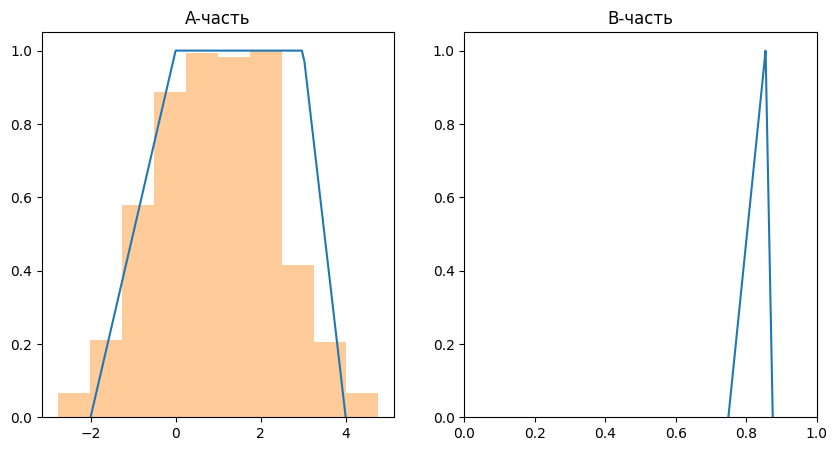

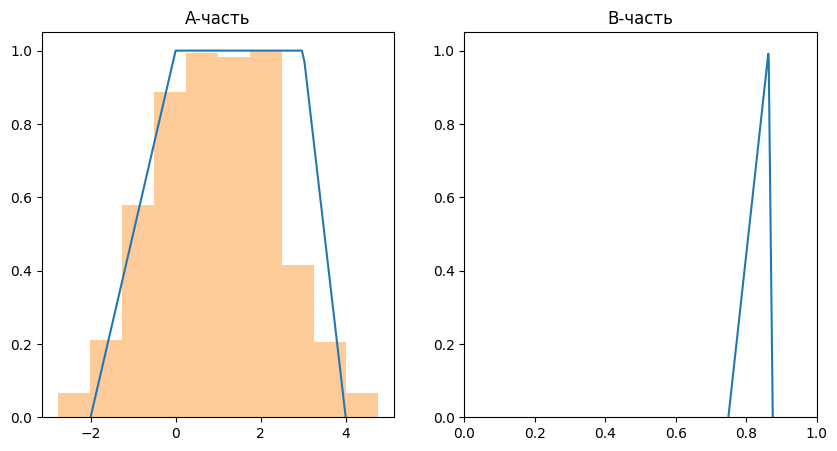

In [61]:
for B in result:
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  A.plot()
  # изобразим также для наглядности гистограмму, отнормированную таким образом, чтобы её максимальное значение было равно 1
  h = np.histogram(data, density=True)
  plt.stairs(h[0] / max(h[0]), h[1], fill=True, color=(1,0.5,0,0.4))
  plt.title('A-часть')
  plt.subplot(1, 2, 2)
  B.plot()
  plt.title('B-часть')
  plt.xlim(0, 1)
  plt.ylim(0, 1.05)
  plt.show()